# The Deutsch-Jozsa Problem

The Deutsch-Jozsa Problem considers a hidden Boolean function $f$ which takes as input a string of bits, and returns either 0 or 1. It is guaranteed to either be balanced or constant. A constant function either always returns 0 for any input, or always returns 1 for any input. A balanced function returns 0 for exactly half of all inputs and 1 for the other half.

Classically, if we want to know whether the function is balanced or constant, we could try two different inputs and be lucky, because if they give different results we know that $f$ is balanced. Or we could be unlucky and have to try half plus one of all the possible inputs, because we just happened to be trying the half of all inputs which all gave the same output.

We can implement $f$ as a quantum circuit. In this case $f$ takes three bits ($q_0$, $q_1$, $q_2$) and returns its output on the fourth bit, $q_3$.


In [1]:
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_bloch_vector, plot_bloch_multivector, plot_distribution, plot_histogram, array_to_latex
from qiskit.result import Result
from qiskit.quantum_info import Statevector, Operator
from qiskit_aer import Aer
from math import sqrt, pi

### use vector_to_latex code from qiskit 0.44
from vector_to_latex import *

In [2]:
qc = QuantumCircuit(4)
qc.barrier()
qc.id(3)
qc.barrier()
qc.draw()

░       ░ 
q_0: ─░───────░─
      ░       ░ 
q_1: ─░───────░─
      ░       ░ 
q_2: ─░───────░─
      ░ ┌───┐ ░ 
q_3: ─░─┤ I ├─░─
      ░ └───┘ ░

This, trivially, would be a constant $f$ which always returns 0, since it will not change $q_3$ from its initial state. Alternatively, a constant $f$ which always returns 1 would be

In [5]:
qc = QuantumCircuit(4,3)
qc.barrier()
qc.x(3)
qc.barrier()
qc.draw()


░       ░ 
q_0: ─░───────░─
      ░       ░ 
q_1: ─░───────░─
      ░       ░ 
q_2: ─░───────░─
      ░ ┌───┐ ░ 
q_3: ─░─┤ X ├─░─
      ░ └───┘ ░ 
c: 3/═══════════

In [6]:
qc = QuantumCircuit(4)
qc.barrier()
qc.cx(0,3)
qc.cx(1,3)
qc.cx(2,3)
qc.barrier()
qc.draw()

░                 ░ 
q_0: ─░───■─────────────░─
      ░   │             ░ 
q_1: ─░───┼────■────────░─
      ░   │    │        ░ 
q_2: ─░───┼────┼────■───░─
      ░ ┌─┴─┐┌─┴─┐┌─┴─┐ ░ 
q_3: ─░─┤ X ├┤ X ├┤ X ├─░─
      ░ └───┘└───┘└───┘ ░

In the case the output will be 0 is there are an even number of 1's in the input, i.e. for 000, 011, 101, 110. It will be 1 for an odd number of 1's, i.e. for 001, 010, 100, 111. We will apply these different inputs with $X$ gates:

In [15]:
f_in = '101'

qc = QuantumCircuit(4)
if f_in[0]=='1': qc.x(0)
if f_in[1]=='1': qc.x(1)
if f_in[2]=='1': qc.x(2)
qc.barrier()
qc.cx(0,3)
qc.cx(1,3)
qc.cx(2,3)
qc.barrier()
display(qc.draw())

svsim = Aer.get_backend('statevector_simulator')
state = svsim.run(qc).result().get_statevector()
result = svsim.run(qc, shots=1, memory=True).result()
print('results: {}'.format(result.get_counts()))
if len(result.get_counts()) > 1:
    raise('superposition')

measure = (list(result.get_counts().keys())[0])[::-1] # reverse to fit qiskit's qubit ordering
print('input: {}{}{}'.format(measure[0],measure[1],measure[2]))
print('output: {}'.format(measure[3]))
# plot_bloch_multivector(state)



┌───┐ ░                 ░ 
q_0: ┤ X ├─░───■─────────────░─
     └───┘ ░   │             ░ 
q_1: ──────░───┼────■────────░─
     ┌───┐ ░   │    │        ░ 
q_2: ┤ X ├─░───┼────┼────■───░─
     └───┘ ░ ┌─┴─┐┌─┴─┐┌─┴─┐ ░ 
q_3: ──────░─┤ X ├┤ X ├┤ X ├─░─
           ░ └───┘└───┘└───┘ ░

results: {np.str_('0101'): np.float64(1.0)}
input: 101
output: 0


We can create different $f$'s by applying $X$ gates before the $CX$ controls, but we should also apply $X$ gates after the $CX$s so that the input bits arrive unchanged at the output. This makes the circuit reversible, as well as hiding which input bits we applied $X$'s to.

┌───┐ ░                           ░ 
q_0: ┤ X ├─░────────■──────────────────░─
     └───┘ ░ ┌───┐  │       ┌───┐      ░ 
q_1: ──────░─┤ X ├──┼────■──┤ X ├──────░─
           ░ ├───┤  │    │  └───┘┌───┐ ░ 
q_2: ──────░─┤ X ├──┼────┼────■──┤ X ├─░─
           ░ └───┘┌─┴─┐┌─┴─┐┌─┴─┐└───┘ ░ 
q_3: ──────░──────┤ X ├┤ X ├┤ X ├──────░─
           ░      └───┘└───┘└───┘      ░

results: {np.str_('1001'): np.float64(1.0)}
input: 100
output: 1


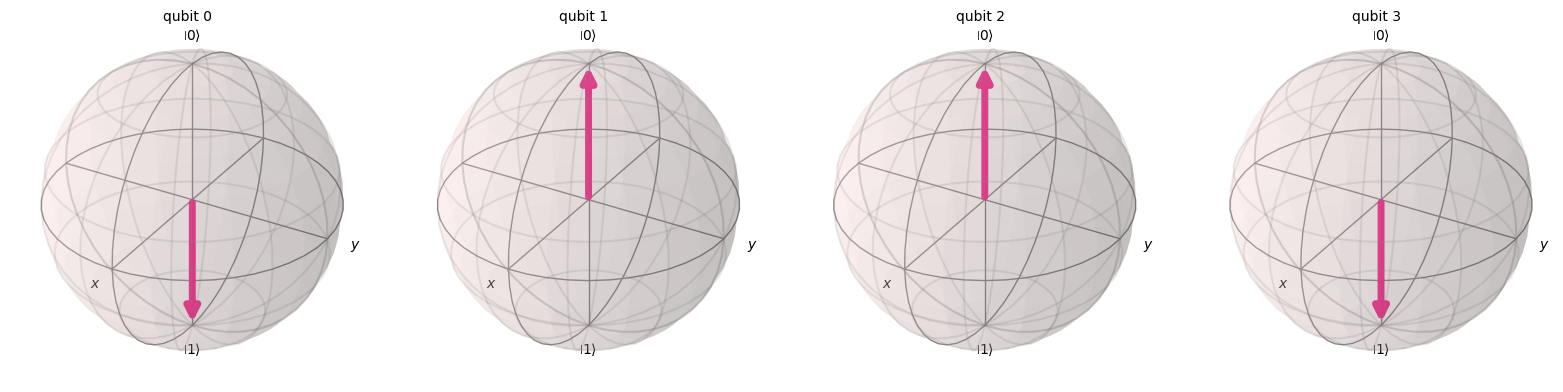

In [17]:

f_in = '100'

b_in = '011'

qc = QuantumCircuit(4)
if f_in[0]=='1': qc.x(0)
if f_in[1]=='1': qc.x(1)
if f_in[2]=='1': qc.x(2)

qc.barrier()
if b_in[0]=='1': qc.x(0)
if b_in[1]=='1': qc.x(1)
if b_in[2]=='1': qc.x(2)
qc.cx(0,3)
qc.cx(1,3)
qc.cx(2,3)
if b_in[0]=='1': qc.x(0)
if b_in[1]=='1': qc.x(1)
if b_in[2]=='1': qc.x(2)
qc.barrier()
display(qc.draw())

svsim = Aer.get_backend('statevector_simulator')
state = svsim.run(qc).result().get_statevector()
result = svsim.run(qc, shots=1, memory=True).result()
print('results: {}'.format(result.get_counts()))
if len(result.get_counts()) > 1:
    raise('superposition')

measure = (list(result.get_counts().keys())[0])[::-1] # reverse to fit qiskit's qubit ordering
print('input: {}{}{}'.format(measure[0],measure[1],measure[2]))
print('output: {}'.format(measure[3]))
#plot_bloch_multivector(state)


How can quantum computing figure out more quickly if the function $f$, known as an "oracle", is constant or balanced? Well, we saw that $CX$ gates can kick the phase back onto the control qubit if they are sent a the right kind of superposition state. Specifically, we put the input qubits into $| + \rangle$ with $H$ and the output qubit into $| - \rangle$ with $X$ $H$.



In [26]:
b_in = '011'

c_out = '0'

cxf = '111'

#case='constant'
case='balanced'

qc = QuantumCircuit(4)
qc.x(3)
for q in range(4):
    qc.h(q)

qc.barrier()

if case=='balanced':
    if b_in[0]=='1': qc.x(0)
    if b_in[1]=='1': qc.x(1)
    if b_in[2]=='1': qc.x(2)
    if cxf[0]=='1': qc.cx(0,3)
    if cxf[1]=='1': qc.cx(1,3)
    if cxf[2]=='1': qc.cx(2,3)
    if b_in[0]=='1': qc.x(0)
    if b_in[1]=='1': qc.x(1)
    if b_in[2]=='1': qc.x(2)

if case=='constant':
    if c_out=='1':
        qc.x(3)
    
qc.barrier()
for q in range(3):
    qc.h(q)

display(qc.draw())

svsim = Aer.get_backend('statevector_simulator')
state = svsim.run(qc).result().get_statevector()
result = svsim.run(qc, shots=1, memory=True).result()
print('results: {}'.format(result.get_counts()))

measure = (list(result.get_counts().keys())[0])[::-1] # reverse to fit qiskit's qubit ordering
print('final state of input bits: {}{}{}'.format(measure[0],measure[1],measure[2]))
#print('output: {}'.format(measure[3]))

if measure[0]=='0' and measure[1]=='0' and measure[2]=='0':
    print('constant oracle')

elif measure[0]=='1' or measure[1]=='1' or measure[2]=='1':
    print('balanced oracle')
    
else:
    print('undefined situation')

┌───┐      ░                           ░ ┌───┐
q_0: ┤ H ├──────░────────■──────────────────░─┤ H ├
     ├───┤      ░ ┌───┐  │       ┌───┐      ░ ├───┤
q_1: ┤ H ├──────░─┤ X ├──┼────■──┤ X ├──────░─┤ H ├
     ├───┤      ░ ├───┤  │    │  └───┘┌───┐ ░ ├───┤
q_2: ┤ H ├──────░─┤ X ├──┼────┼────■──┤ X ├─░─┤ H ├
     ├───┤┌───┐ ░ └───┘┌─┴─┐┌─┴─┐┌─┴─┐└───┘ ░ └───┘
q_3: ┤ X ├┤ H ├─░──────┤ X ├┤ X ├┤ X ├──────░──────
     └───┘└───┘ ░      └───┘└───┘└───┘      ░

results: {np.str_('0111'): np.float64(0.5), np.str_('1111'): np.float64(0.5)}
final state of input bits: 111
balanced oracle


So a constant oracle will always give $000$ on the input bits while a balanced oracle will always give at least one $1$ on the input bits. This is just because, if we apply $H$ and then $H$ to a qubit which started as $| 0 \rangle$, it will return to $| 0 \rangle$. But if we apply $| + \rangle$ to the control qubit of a $CX$ with its output in $| - \rangle$ we will flip the *control* qubit to $| - \rangle$ by phase kickback, and if we apply $H$ to that we end up with $| 1 \rangle$. Alternatively, if we used $X$ gates on one of the qubits in the oracle to change its behaviour, $| + \rangle$ gets flipped to $| - \rangle$ by the first $X$ gate, is flipped back to $| + \rangle$ by phase kickback, and then is flipped again to $| - \rangle$ by the second $X$ gate.

# Bernstein-Vazirani Algorithim

That was admittedly a rather contrived example, and we didn't learn very much about the structure of the oracle even if we did manage to learn whether it was constant or balanced in one shot rather than having to try about half the possible inputs. Let's consider an oracle which performs a specific operation to return an output based on the input qubits:$$ f_s(x) = s \cdot x\qquad \mod \, 2$$

What this means is that for a given input string $x$, the oracle performd the bitwise product(bit and'&') with some hidden string $s$ and the output is 0 or 1 depending on whether $x$ and $s$ have an even or odd number of 1 bits in common.


In [28]:
x_in = '101'

s = '011'
qc = QuantumCircuit(4)

x_in = x_in[::-1] # reverse x to fit qiskit's qubit ordering
if x_in[0]=='1': qc.x(0)
if x_in[1]=='1': qc.x(1)
if x_in[2]=='1': qc.x(2)

qc.barrier()

s = s[::-1] # reverse s to fit qiskit's qubit ordering
for q in range(3):
    if s[q] == '0':
        qc.id(q)
    else:
        qc.cx(q, 3)

qc.barrier()
display(qc.draw())

svsim = Aer.get_backend('statevector_simulator')
state = svsim.run(qc).result().get_statevector()
result = svsim.run(qc, shots=1, memory=True).result()
print('results: {}'.format(result.get_counts()))
if len(result.get_counts()) > 1:
    raise('superposition')

measure = (list(result.get_counts().keys())[0])[::-1] # reverse to fit qiskit's qubit ordering
print('input: {}{}{}'.format(measure[2],measure[1],measure[0]))
print('output: {}'.format(measure[3]))
# plot_bloch_multivector(state)

┌───┐ ░                 ░ 
q_0: ┤ X ├─░───■─────────────░─
     └───┘ ░   │             ░ 
q_1: ──────░───┼─────────■───░─
     ┌───┐ ░   │  ┌───┐  │   ░ 
q_2: ┤ X ├─░───┼──┤ I ├──┼───░─
     └───┘ ░ ┌─┴─┐└───┘┌─┴─┐ ░ 
q_3: ──────░─┤ X ├─────┤ X ├─░─
           ░ └───┘     └───┘ ░

results: {np.str_('1101'): np.float64(1.0)}
input: 101
output: 1


To figure out the secret string classically, we should test this three-bit oracle three times, once for each bit

In [30]:
sbit=0
sout=[]
for x_in in ['001', '010', '100']:
    s = '011'
    qc = QuantumCircuit(4)

    x_in = x_in[::-1] # reverse to fit qiskit's qubit ordering
    if x_in[0]=='1': qc.x(0)
    if x_in[1]=='1': qc.x(1)
    if x_in[2]=='1': qc.x(2)

    qc.barrier()

    s = s[::-1] # reverse to fit qiskit's qubit ordering
    for q in range(3):
        if s[q] == '0':
            qc.id(q)
        else:
            qc.cx(q, 3)

    qc.barrier()
    display(qc.draw())

    svsim = Aer.get_backend('statevector_simulator')
    state = svsim.run(qc).result().get_statevector()
    result = svsim.run(qc, shots=1, memory=True).result()
    print('results: {}'.format(result.get_counts()))
    if len(result.get_counts()) > 1:
        raise('superposition')

    measure = (list(result.get_counts().keys())[0])[::-1] # reverse to fit qiskit's qubit ordering
    print('input: {}{}{}'.format(measure[2],measure[1],measure[0]))
    print('output: {} so bit {} of s is {}'.format(measure[3],sbit,measure[3]))
    sout.append(measure[3])
    sbit=sbit+1

print('\nhidden string is {}{}{}'.format(sout[2],sout[1],sout[0]))

┌───┐ ░                 ░ 
q_0: ┤ X ├─░───■─────────────░─
     └───┘ ░   │             ░ 
q_1: ──────░───┼─────────■───░─
           ░   │  ┌───┐  │   ░ 
q_2: ──────░───┼──┤ I ├──┼───░─
           ░ ┌─┴─┐└───┘┌─┴─┐ ░ 
q_3: ──────░─┤ X ├─────┤ X ├─░─
           ░ └───┘     └───┘ ░

results: {np.str_('1001'): np.float64(1.0)}
input: 001
output: 1 so bit 0 of s is 1


░                 ░ 
q_0: ──────░───■─────────────░─
     ┌───┐ ░   │             ░ 
q_1: ┤ X ├─░───┼─────────■───░─
     └───┘ ░   │  ┌───┐  │   ░ 
q_2: ──────░───┼──┤ I ├──┼───░─
           ░ ┌─┴─┐└───┘┌─┴─┐ ░ 
q_3: ──────░─┤ X ├─────┤ X ├─░─
           ░ └───┘     └───┘ ░

results: {np.str_('1010'): np.float64(1.0)}
input: 010
output: 1 so bit 1 of s is 1


░                 ░ 
q_0: ──────░───■─────────────░─
           ░   │             ░ 
q_1: ──────░───┼─────────■───░─
     ┌───┐ ░   │  ┌───┐  │   ░ 
q_2: ┤ X ├─░───┼──┤ I ├──┼───░─
     └───┘ ░ ┌─┴─┐└───┘┌─┴─┐ ░ 
q_3: ──────░─┤ X ├─────┤ X ├─░─
           ░ └───┘     └───┘ ░

results: {np.str_('0100'): np.float64(1.0)}
input: 100
output: 0 so bit 2 of s is 0

hidden string is 011


Of course we can figure out the hidden string in one shot using phase kickback tell us which input qubits are connected to $CX$ gates.

In [31]:
s = '011'
qc = QuantumCircuit(4)

qc.x(3)
for q in range(4):
    qc.h(q)

qc.barrier()

s = s[::-1] # reverse s to fit qiskit's qubit ordering
for q in range(3):
    if s[q] == '0':
        qc.id(q)
    else:
        qc.cx(q, 3)

qc.barrier()
for q in range(4):
    qc.h(q)

display(qc.draw())

svsim = Aer.get_backend('statevector_simulator')
state = svsim.run(qc).result().get_statevector()
result = svsim.run(qc, shots=1, memory=True).result()
print('results: {}'.format(result.get_counts()))
if len(result.get_counts()) > 1:
    raise('superposition')

measure = (list(result.get_counts().keys())[0])[::-1] # reverse to fit qiskit's qubit ordering
print('hidden string is: {}{}{}'.format(measure[2],measure[1],measure[0]))
# print('output: {}'.format(measure[3]))
# plot_bloch_multivector(state)

┌───┐      ░                 ░ ┌───┐
q_0: ┤ H ├──────░───■─────────────░─┤ H ├
     ├───┤      ░   │             ░ ├───┤
q_1: ┤ H ├──────░───┼─────────■───░─┤ H ├
     ├───┤      ░   │  ┌───┐  │   ░ ├───┤
q_2: ┤ H ├──────░───┼──┤ I ├──┼───░─┤ H ├
     ├───┤┌───┐ ░ ┌─┴─┐└───┘┌─┴─┐ ░ ├───┤
q_3: ┤ X ├┤ H ├─░─┤ X ├─────┤ X ├─░─┤ H ├
     └───┘└───┘ ░ └───┘     └───┘ ░ └───┘

results: {np.str_('1011'): np.float64(1.0)}
hidden string is: 011


In a quantum circuit a 'black box' like our oracle is not literally a circuit hidden in a box, but rather a sequence of operations on qubits which we need to tell our quantum computer to perform. It's debatable how hidden the hidden string really is if we have to program it in ourselves. However, we could imagine that we physically do not know which qubits are able to interact with each other to perform $CX$ operations and this would be a way to find out.

┌───┐┌───┐┌───┐
q: ┤ X ├┤ H ├┤ H ├
   └───┘└───┘└───┘

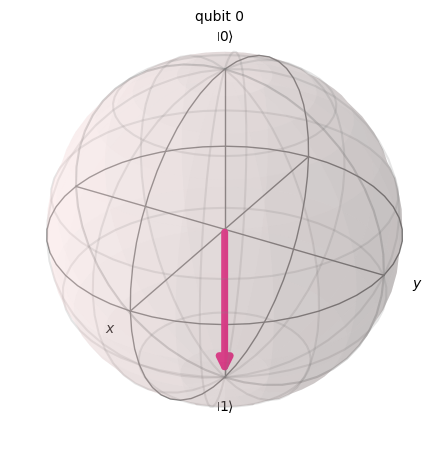

<IPython.core.display.Math object>

<IPython.core.display.Latex object>

In [39]:
qc = QuantumCircuit(1)

qc.x(0)
qc.h(0)

qc.h(0)

display(qc.draw())
state = Statevector(qc)
display(state.draw(output='bloch'))
display(Math(vector_to_latex(state)))
display(state.draw(output='latex'))